<a href="https://colab.research.google.com/github/samsinar/Klasifikasi_Daun/blob/main/SLO_Samsinar_Ilyas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
ls

In [4]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from imutils import paths
import numpy as np
import os

In [5]:
# grab all image paths in the input dataset directory, then initialize
# our list of images and corresponding class labels
print("[INFO] loading images...")
imagePaths = paths.list_images("Dataset_daun")
data = []
labels = []

[INFO] loading images...


In [6]:
# loop over our input images
for imagePath in imagePaths:
	# load the input image from disk, resize it to 32x32 pixels, scale
	# the pixel intensities to the range [0, 1], and then update our
	# images list
	image = Image.open(imagePath)
	image = np.array(image.resize((224, 224))) / 255.0 #normalisasi
	data.append(image)

	# extract the class label from the file path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

In [7]:
print(labels)

['GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03', 'GMB_03',

In [8]:
# encode the labels, converting them from strings to integers
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [9]:
print(labels)

[[0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 ...
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]


In [10]:
# perform a training and testing split, using 75% of the data for
# training and 25% for evaluation
(trainX, testX, trainY, testY) = train_test_split(np.array(data),	np.array(labels), test_size=0.25, shuffle=True)
print(trainX.shape)
print(testX.shape)

(438, 224, 224, 3)
(147, 224, 224, 3)


In [11]:
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, BatchNormalization

In [33]:
from keras.layers import Dropout
base_model = MobileNet(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
out = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

In [34]:
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   mode='auto',
                   restore_best_weights=True)
checkpoint = ModelCheckpoint('best_weight_scene_mobileNet.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',)

In [35]:
# train the model using the Adam optimizer
print("[INFO] training network...")
opt = Adam(lr=1e-3, decay=1e-3 / 50)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=32, callbacks=[es, checkpoint])

[INFO] training network...
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.7908 - accuracy: 0.7352
Epoch 00001: val_accuracy improved from -inf to 0.31293, saving model to best_weight_scene_mobileNet.h5
14/14 [==============================] - 84s 6s/step - loss: 0.7908 - accuracy: 0.7352 - val_loss: 6.1525 - val_accuracy: 0.3129
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9224
Epoch 00002: val_accuracy improved from 0.31293 to 0.53741, saving model to best_weight_scene_mobileNet.h5
14/14 [==============================] - 84s 6s/step - loss: 0.2591 - accuracy: 0.9224 - val_loss: 4.3364 - val_accuracy: 0.5374
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9429
Epoch 00003: val_accuracy did not improve from 0.53741
14/14 [==============================] - 84s 6s/step - loss: 0.1559 - accuracy: 0.9429 - val_loss: 6.2224 - val_accuracy: 0.3537
Epoch 4/100
14/14 [================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


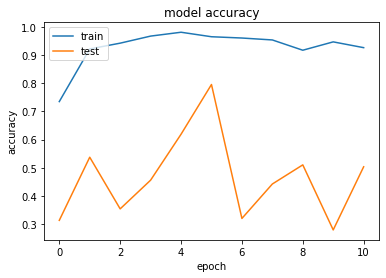

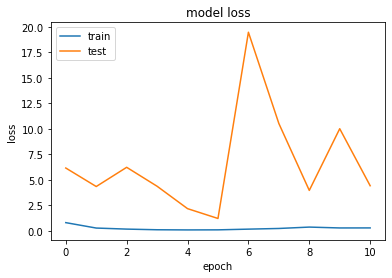

In [36]:
import matplotlib.pyplot as plt

print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

      GMB_01       0.55      0.96      0.70        24
      GMB_03       1.00      0.43      0.60        21
      GMB_05       1.00      0.65      0.79        43
      GMB_07       0.88      0.97      0.92        29
      GMB_09       0.81      0.97      0.88        30

    accuracy                           0.80       147
   macro avg       0.85      0.79      0.78       147
weighted avg       0.86      0.80      0.79       147

